### Install the library and toolboxs

In [1]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!apt-get install python3-openslide

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 25 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 1s (151 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 144568 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2_amd64.deb ...
Unpacking libopenslide0 (3.4.1+dfsg-2) ...
Selecting previously unselected package openslide-tools.
Preparing to unpack 

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import random
import shutil
import time
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
from PIL import Image
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split

!pip install ipython-autotime

%load_ext autotime
%tensorflow_version 2.x
import tensorflow as tf

  Created wheel for ipython-autotime: filename=ipython_autotime-0.1-cp36-none-any.whl size=1832 sha256=798dc42b348315d980b887b041b5e13a1d70b231aec21292d98494face4fe988
  Stored in directory: /root/.cache/pip/wheels/d2/df/81/2db1e54bc91002cec40334629bc39cfa86dff540b304ebcd6e
Successfully built ipython-autotime


# Extract the data for training (first 19/21 slides)

### Get the path of original dataset from google drive folder (assumming data is stored in there)

In [0]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive/')

In [0]:
# Get the slides and masks path
import re

slides_dir = "/content/drive/My Drive/slides"
list_files = os.listdir(slides_dir)

def filter_path(file_path):
    if re.findall("[0-9].tif", file_path):
        # Slide
        return 1
    elif re.findall("_mask.tif", file_path):
        # Mask
        return 2
    else:
        return 0

name_slides = list(filter(lambda x: filter_path(x) == 1, list_files))
name_masks = list(filter(lambda x: filter_path(x) == 2, list_files))

# Make full path
path_slides = []
path_masks = []
for name_slide in name_slides[:-2]:
    # Skip slide 38, no mask file
    if name_slide == "tumor_038.tif":
        continue

    name_mask = name_slide[:-4] + "_mask.tif"
    path_slides.append(os.path.join(slides_dir, name_slide))
    path_masks.append(os.path.join(slides_dir, name_mask))
    assert name_slide == (name_mask[:-9] + ".tif")
    assert name_mask in name_masks

# Check the paths
for path_slide, path_mask in zip(path_slides, path_masks):
  print(path_slide, path_mask)

/content/drive/My Drive/slides/tumor_091.tif /content/drive/My Drive/slides/tumor_091_mask.tif
/content/drive/My Drive/slides/tumor_001.tif /content/drive/My Drive/slides/tumor_001_mask.tif
/content/drive/My Drive/slides/tumor_002.tif /content/drive/My Drive/slides/tumor_002_mask.tif
/content/drive/My Drive/slides/tumor_005.tif /content/drive/My Drive/slides/tumor_005_mask.tif
/content/drive/My Drive/slides/tumor_012.tif /content/drive/My Drive/slides/tumor_012_mask.tif
/content/drive/My Drive/slides/tumor_016.tif /content/drive/My Drive/slides/tumor_016_mask.tif
/content/drive/My Drive/slides/tumor_019.tif /content/drive/My Drive/slides/tumor_019_mask.tif
/content/drive/My Drive/slides/tumor_023.tif /content/drive/My Drive/slides/tumor_023_mask.tif
/content/drive/My Drive/slides/tumor_031.tif /content/drive/My Drive/slides/tumor_031_mask.tif
/content/drive/My Drive/slides/tumor_035.tif /content/drive/My Drive/slides/tumor_035_mask.tif
/content/drive/My Drive/slides/tumor_057.tif /cont

### Functions to read images and extract patches

In [0]:
# Read a region from the slide and return a numpy RBG array
from skimage.color import rgb2gray
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

# Make patches for training by sliding a window across slides 
# (Note that for patches without tumor, we just accept those with cells.
# The criteria are mean standard deviation across color channel and mean intensity after converted to gray.
# This is to save RAM and to make training set informative.)
def make_patch_set(slide_paths, mask_paths, patch_size=100, level=4):
    slide_patches = []
    tumor_indicator = []
    threshold_std = 5
    threshold_intensity = 0.2

    for slide_path, mask_path in zip(slide_paths, mask_paths):
        slide_whole = open_slide(slide_path)
        tumor_mask = open_slide(mask_path)
        n_step_width = tumor_mask.level_dimensions[level][0] // patch_size
        n_step_height = tumor_mask.level_dimensions[level][1] // patch_size
        downsample_factor = tumor_mask.level_downsamples[level]                 
        for step_width in range(n_step_width):
          for step_height in range(n_step_height):
              slide_window = [int(patch_size * step_width * downsample_factor), int(patch_size * step_height * downsample_factor)] 

              # Slide
              slide_patch = read_slide(slide_whole, 
                                    x=slide_window[0], 
                                    y=slide_window[1], 
                                    level=level, 
                                    width=patch_size, 
                                    height=patch_size)   
                        
              # Mask
              im_mask = read_slide(tumor_mask, 
                                    x=slide_window[0], 
                                    y=slide_window[1], 
                                    level=level, 
                                    width=patch_size, 
                                    height=patch_size) 
              
              # Only save those patches that contain cells
              if np.mean(np.std(slide_patch, axis=-1)) > threshold_std:
                  slide_patches.append(slide_patch)  
                  if np.sum(im_mask[:,:,0]) > 0:
                    tumor_indicator.append(1)
                  else:
                    tumor_indicator.append(0)

    return slide_patches, tumor_indicator

# Make patches (Note that here we include all patches, even those without cells.
# This is important to check if our patch extraction works. 
# So this is recommended to use first to check. The downside is it takes a lot of RAM for high resolution)
def make_patch_set_include_all(slide_paths, mask_paths, patch_size=100, level=4):
    slide_patches = []
    tumor_indicator = []
    threshold_std = 5
    threshold_intensity = 0.2

    for slide_path, mask_path in zip(slide_paths, mask_paths):
        slide_whole = open_slide(slide_path)
        tumor_mask = open_slide(mask_path)
        n_step_width = tumor_mask.level_dimensions[level][0] // patch_size
        n_step_height = tumor_mask.level_dimensions[level][1] // patch_size
        downsample_factor = tumor_mask.level_downsamples[level]                 
        for step_width in range(n_step_width):
          for step_height in range(n_step_height):
              slide_window = [int(patch_size * step_width * downsample_factor), int(patch_size * step_height * downsample_factor)] 

              # Slide
              slide_patch = read_slide(slide_whole, 
                                    x=slide_window[0], 
                                    y=slide_window[1], 
                                    level=level, 
                                    width=patch_size, 
                                    height=patch_size)   
                        
              # Mask
              im_mask = read_slide(tumor_mask, 
                                    x=slide_window[0], 
                                    y=slide_window[1], 
                                    level=level, 
                                    width=patch_size, 
                                    height=patch_size) 
              
              # Save all patches
              slide_patches.append(slide_patch)  
              if np.sum(im_mask[:,:,0]) > 0:
                tumor_indicator.append(1)
              else:
                tumor_indicator.append(0)

    return slide_patches, tumor_indicator

time: 79.8 ms


#### Check percent of tumor/no-tumor slides

In [0]:
# # Check percent of tumor/no-tumor slides
# is_tumor = []
# level = 7
# for path_mask in path_masks:
#     tumor_mask = open_slide(path_mask)
#     im_mask = read_slide(tumor_mask, 
#                          x=0, 
#                          y=0, 
#                          level=level, 
#                          width=tumor_mask.level_dimensions[level][0], 
#                          height=tumor_mask.level_dimensions[level][1])
#     sum_tumor_pix = np.sum(im_mask[:, :, 0])
#     if sum_tumor_pix > 0:
#         is_tumor.append(1)
#     else:
#         is_tumor.append(0)

# print("Percent of tumor slides: {:.1f}%".format(sum(is_tumor) / len(is_tumor) * 100))

time: 451 µs


## Extract the patches with "make_patch_set"
There is no need to extract patches with cells only for patches without tumor. This is faster and saves a ton of RAM but we should use "make_patch_set_include_all" first to check if our patch extraction works


In [0]:
# Extract the patches and labels
level = 3
patch_size = 32
slide_patches, tumor_indicator = make_patch_set(path_slides, path_masks, patch_size=patch_size, level=level)

# Save the variables    
variable_folder =  "/content/drive/My Drive/Dataset"
file_name = "dataset_preprocessed" + "_level" + str(level) + "_unbalanced.pkl"
if os.path.isdir(variable_folder)==False:
    os.mkdir(variable_folder)

with open(os.path.join(variable_folder, file_name), 'wb') as f:
    pickle.dump([slide_patches, tumor_indicator], f, protocol=-1)

time: 50min 23s


In [0]:
# Compute the number of patches with tumor
n_patch = len(tumor_indicator)
n_patch_tumor = sum(tumor_indicator)
print("Percent of patches with tumor: {:.1f}% ({:d}/{:d})".format(n_patch_tumor/n_patch*100, n_patch_tumor, n_patch))


Percent of patches with tumor: 7.0% (30604/434379)
time: 4.11 ms


In [0]:
# Create balanced dataset
slide_patches_tumor = [slide_patches[i] for i in range(n_patch) if tumor_indicator[i]==1]
slide_patches_notumor = [slide_patches[i] for i in range(n_patch) if tumor_indicator[i]==0]
index_shuffle = np.arange(len(slide_patches_notumor))
dataset_patches = slide_patches_tumor + [slide_patches_notumor[index_shuffle[i]] for i in index_shuffle[:n_patch_tumor]]
dataset_label = np.hstack((np.ones((n_patch_tumor,)), np.zeros((n_patch_tumor,))))

time: 315 ms


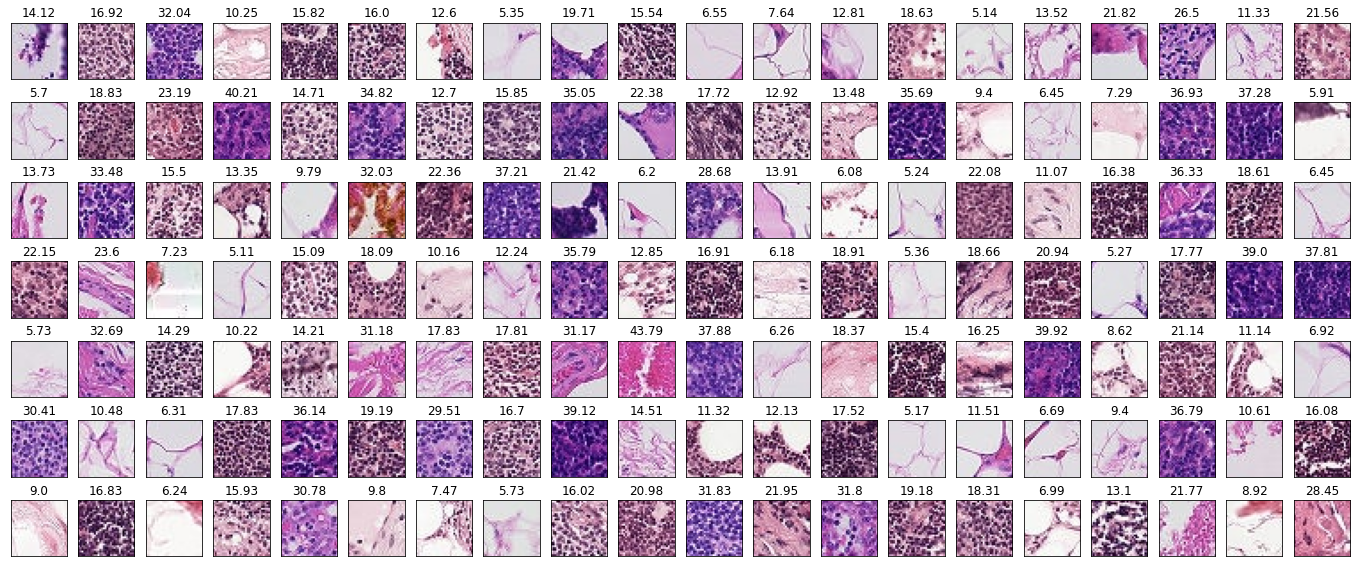

time: 7.38 s


In [0]:
# Check the patches without tumor to see if they contain cells
slide_patches_notumor_cell = slide_patches_notumor
index_shuffle = np.arange(len(slide_patches_notumor_cell))
np.random.shuffle(index_shuffle)
dim_axis = [20, 7]
fig = plt.figure(figsize=(24,10))
for i in range(dim_axis[1]):
    for j in range(dim_axis[0]):
        ax = fig.add_subplot(dim_axis[1], dim_axis[0], i*dim_axis[0]+j+1)
        plt.imshow(slide_patches_notumor_cell[index_shuffle[i*dim_axis[0]+j]])
        im_gray = rgb2gray(slide_patches_notumor_cell[index_shuffle[i*dim_axis[0]+j]])
        std_cross_channel = np.std(slide_patches_notumor_cell[index_shuffle[i*dim_axis[0]+j]], axis=-1)
        # ax.set_title(str(round(np.mean(im_gray), 2)) + ", " + str(round(np.mean(std_cross_channel), 2)))
        ax.set_title(str(round(np.mean(std_cross_channel), 2)))
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)

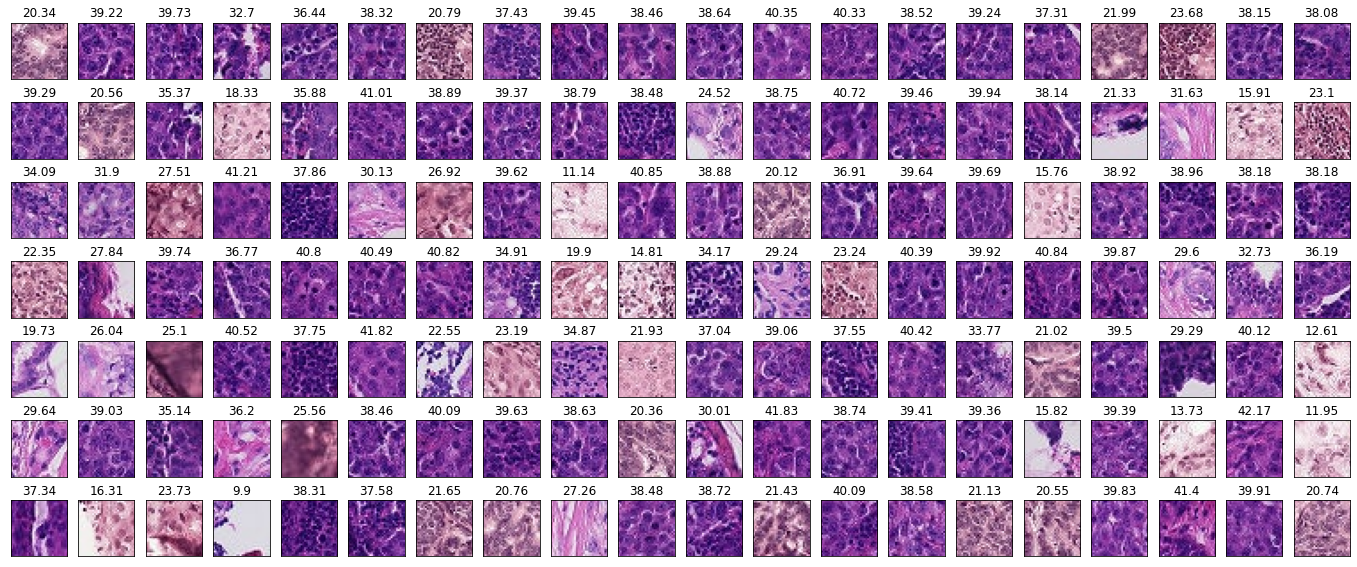

time: 5.91 s


In [0]:
# Check the patches with tumor to see if they contain cells
index_shuffle = np.arange(len(slide_patches_tumor))
np.random.shuffle(index_shuffle)
dim_axis = [20, 7]
fig = plt.figure(figsize=(24,10))
for i in range(dim_axis[1]):
    for j in range(dim_axis[0]):
        ax = fig.add_subplot(dim_axis[1], dim_axis[0], i*dim_axis[0]+j+1)
        plt.imshow(slide_patches_tumor[index_shuffle[i*dim_axis[0]+j]])
        im_gray = rgb2gray(slide_patches_tumor[index_shuffle[i*dim_axis[0]+j]])
        std_cross_channel = np.std(slide_patches_tumor[index_shuffle[i*dim_axis[0]+j]], axis=-1)
        # ax.set_title(str(round(np.mean(im_gray), 2)) + ", " + str(round(np.mean(std_cross_channel), 2)))
        ax.set_title(str(round(np.mean(std_cross_channel), 2)))
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)

In [0]:
# Save the variables
file_name = "dataset_preprocessed" + "_level" + str(level) + "_balanced.pkl"
if os.path.isdir(variable_folder)==False:
    os.mkdir(variable_folder)

with open(os.path.join(variable_folder, file_name), 'wb') as f:
    pickle.dump([dataset_patches, dataset_label], f, protocol=-1)

time: 3.26 s


## Extract and create a balance dataset with "make_patch_set_include_all"
**Note that this is used in couple with "make_patch_set_include_all". Because we include all patches, we have to extract the patches with cells only. Also, this is good to check if our patch extraction works.**

We want to have the same number of patches with tumor and without tumor.
Also we want those patches without tumor is not background only, that is, it has to contain some cell. The threshold is mean standard deviation across color channel and mean intensity after converted to gray. I observe that patch with cell has color (i.e. variance is large across channel) whereas non-cell patches have no color.

#### Extract patches

In [0]:
# Extract the patches and labels
level = 1
patch_size = 32
slide_patches, tumor_indicator = make_patch_set_include_all(path_slides, path_masks, patch_size=patch_size, level=level)

# Save the variables    
variable_folder =  "/content/drive/My Drive/Dataset"

if os.path.isdir(variable_folder)==False:
    os.mkdir(variable_folder)

with open(os.path.join(variable_folder, "dataset_original.pkl"), 'wb') as f:
    pickle.dump([slide_patches, tumor_indicator], f, protocol=-1)

In [0]:
# # Load the extracted patches
# variable_folder =  "/content/drive/My Drive/Dataset"

# with open(os.path.join(variable_folder, "dataset_original.pkl"), 'rb') as f:
#     slide_patches, tumor_indicator = pickle.load(f)

time: 1min 12s


#### Plot to see if patch extraction works

In [0]:
# Get the index of first patch for each slide
# Also check the number of tumor patches in each slide
level = 4
patch_size = 32
index_first_patch = [0]
previous_index = 0
for count, slide_mask in enumerate(path_masks[:-1]):
    # Print the number of patches
    n_patch_tumor_each_slide = sum(tumor_indicator[previous_index:previous_index+n_step_width*n_step_height])
    print("Slide {:d}: {:d} patches".format(count, n_patch_tumor_each_slide))  

    # Get the index
    tumor_mask = open_slide(slide_mask)
    im_width =  tumor_mask.level_dimensions[level][0]
    im_height =  tumor_mask.level_dimensions[level][1]
    n_step_width = im_width // patch_size
    n_step_height = im_height // patch_size
    index_first_patch.append(previous_index + n_step_width * n_step_height)
    previous_index = previous_index + n_step_width * n_step_height

n_patch_tumor_each_slide = sum(tumor_indicator[previous_index:])
print("Slide {:d}: {:d} patches".format(count+1, n_patch_tumor_each_slide)) 

Slide 0: 285 patches
Slide 1: 0 patches
Slide 2: 10 patches
Slide 3: 25 patches
Slide 4: 10 patches
Slide 5: 735 patches
Slide 6: 25 patches
Slide 7: 25 patches
Slide 8: 834 patches
Slide 9: 5 patches
Slide 10: 32 patches
Slide 11: 6 patches
Slide 12: 726 patches
Slide 13: 5192 patches
Slide 14: 3639 patches
Slide 15: 9 patches
Slide 16: 247 patches
Slide 17: 1 patches
Slide 18: 2585 patches
Slide 19: 4776 patches
Slide 20: 948 patches
time: 1.14 s


Plot the original image with mask and the patches put together to see if patch extraction works properly.

In [0]:
# Load the whole slide
slide_to_plot = 19
slide_whole = open_slide(path_slides[slide_to_plot])
im_width =  slide_whole.level_dimensions[level][0]
im_height =  slide_whole.level_dimensions[level][1]
im_slide_whole = read_slide(slide_whole, 
                      x=0, 
                      y=0, 
                      level=level, 
                      width=im_width, 
                      height=im_height)   

         
# Load the whole mask
tumor_mask = open_slide(path_masks[slide_to_plot])
im_mask_whole = read_slide(tumor_mask, 
                      x=0, 
                      y=0, 
                      level=level, 
                      width=im_width, 
                      height=im_height)     


# Plot the whole slide and patches
n_step_width = im_width // patch_size
n_step_height = im_height // patch_size
canvas_slide = Image.new('RGB', (patch_size * n_step_width, patch_size * n_step_height), 'white')
canvas_mask = Image.new('RGB', (patch_size * n_step_width, patch_size * n_step_height), 'white')
mask_blank = np.zeros((patch_size, patch_size))
mask_tumor = 255 * np.ones((patch_size, patch_size))
index = index_first_patch[slide_to_plot]
for i in range(n_step_width):
    for j in range(n_step_height):
        canvas_slide.paste(Image.fromarray(slide_patches[index], 'RGB'), (i*patch_size, j*patch_size))
        if tumor_indicator[index] == 0:
            canvas_mask.paste(Image.fromarray(mask_blank), (i*patch_size, j*patch_size))
        else:
            canvas_mask.paste(Image.fromarray(mask_tumor), (i*patch_size, j*patch_size))
        index += 1

slide_name = 'patch_to_slide.png'
mask_name = 'patch_to_mask.png'
canvas_slide.save(slide_name)
canvas_mask.save(mask_name)
image_slide = plt.imread(slide_name)
image_mask = plt.imread(mask_name)

fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(121)
plt.imshow(im_slide_whole)
plt.imshow(im_mask_whole[:, :, 0], cmap='Reds', alpha=0.7)
ax2 = fig.add_subplot(122)
plt.imshow(image_slide)
plt.imshow(image_mask, cmap='Reds', alpha=0.7)

Plot only the tumor areas to check the patches

In [0]:
# # Plot the area with tumor
# x_plot = [2800, 3000]
# y_plot = [6400, 6600]
# fig = plt.figure(figsize=(15,15))
# ax1 = fig.add_subplot(121)
# plt.imshow(im_slide_whole[y_plot[0]:y_plot[1], x_plot[0]:x_plot[1], :])
# plt.imshow(im_mask_whole[y_plot[0]:y_plot[1], x_plot[0]:x_plot[1], 0], cmap='Reds', alpha=0.5)
# ax2 = fig.add_subplot(122)
# plt.imshow(image_slide[y_plot[0]:y_plot[1], x_plot[0]:x_plot[1], :])
# plt.imshow(image_mask[y_plot[0]:y_plot[1], x_plot[0]:x_plot[1], :], cmap='Reds', alpha=0.5)

#### Create a balanced dataset and check the images

In [0]:
# Compute the number of patches with tumor
n_patch = len(tumor_indicator)
n_patch_tumor = sum(tumor_indicator)
print("Percent of patches with tumor: {:.1f}% ({:d}/{:d})".format(n_patch_tumor/n_patch*100, n_patch_tumor, n_patch))


Percent of patches with tumor: 1.1% (14304/1266294)
time: 8.83 ms


In [0]:
# Create a balanced dataset
from skimage.color import rgb2gray
slide_patches_tumor = [slide_patches[i] for i in range(n_patch) if tumor_indicator[i]==1]
slide_patches_notumor = [slide_patches[i] for i in range(n_patch) if tumor_indicator[i]==0]
n_patches_per_slide = int(n_patch / len(path_slides))
n_patches_tumor_per_slide = int(n_patch_tumor / len(path_slides)) + 1
n_patches_no_tumor = n_patch - n_patch_tumor
slide_patches_notumor_cell = []
slide_patches_notumor_background = []
threshold_std = 5
threshold_intensity = 0.2
for ind_slide in range(len(path_slides)):
    count = 0
    for ind_patch in range(n_patches_per_slide):
        ind_select = ind_patch + ind_slide * n_patches_per_slide
        im_patch = slide_patches_notumor[ind_select]
        im_gray = rgb2gray(im_patch)
        if np.mean(np.std(im_patch, axis=-1)) > threshold_std and np.mean(im_gray) > threshold_intensity:
            slide_patches_notumor_cell.append(im_patch)
            count += 1

        if count == n_patches_tumor_per_slide or ind_select == n_patches_no_tumor-1:
            break

dataset_patches = slide_patches_tumor + slide_patches_notumor_cell
dataset_label = np.hstack((np.ones((n_patch_tumor,)), np.zeros((n_patch_tumor,))))

time: 54.7 s


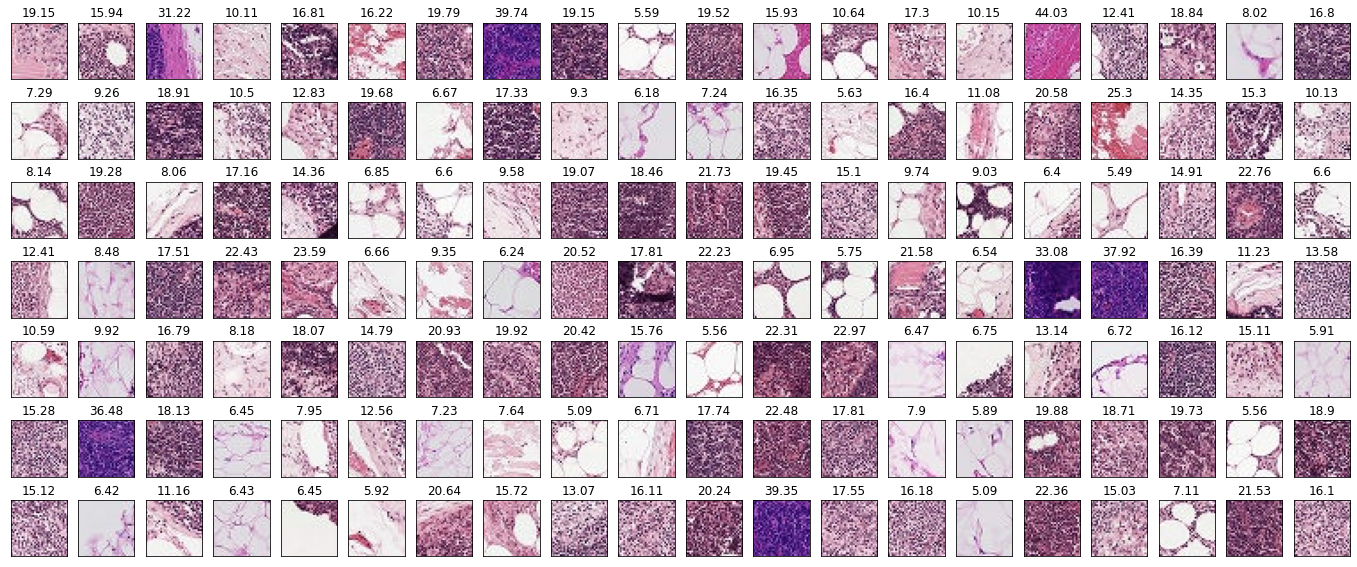

time: 5.87 s


In [0]:
# Check the patches without tumor to see if they contain cells
index_shuffle = np.arange(len(slide_patches_notumor_cell))
np.random.shuffle(index_shuffle)
dim_axis = [20, 7]
fig = plt.figure(figsize=(24,10))
for i in range(dim_axis[1]):
    for j in range(dim_axis[0]):
        ax = fig.add_subplot(dim_axis[1], dim_axis[0], i*dim_axis[0]+j+1)
        plt.imshow(slide_patches_notumor_cell[index_shuffle[i*dim_axis[0]+j]])
        im_gray = rgb2gray(slide_patches_notumor_cell[index_shuffle[i*dim_axis[0]+j]])
        std_cross_channel = np.std(slide_patches_notumor_cell[index_shuffle[i*dim_axis[0]+j]], axis=-1)
        # ax.set_title(str(round(np.mean(im_gray), 2)) + ", " + str(round(np.mean(std_cross_channel), 2)))
        ax.set_title(str(round(np.mean(std_cross_channel), 2)))
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)

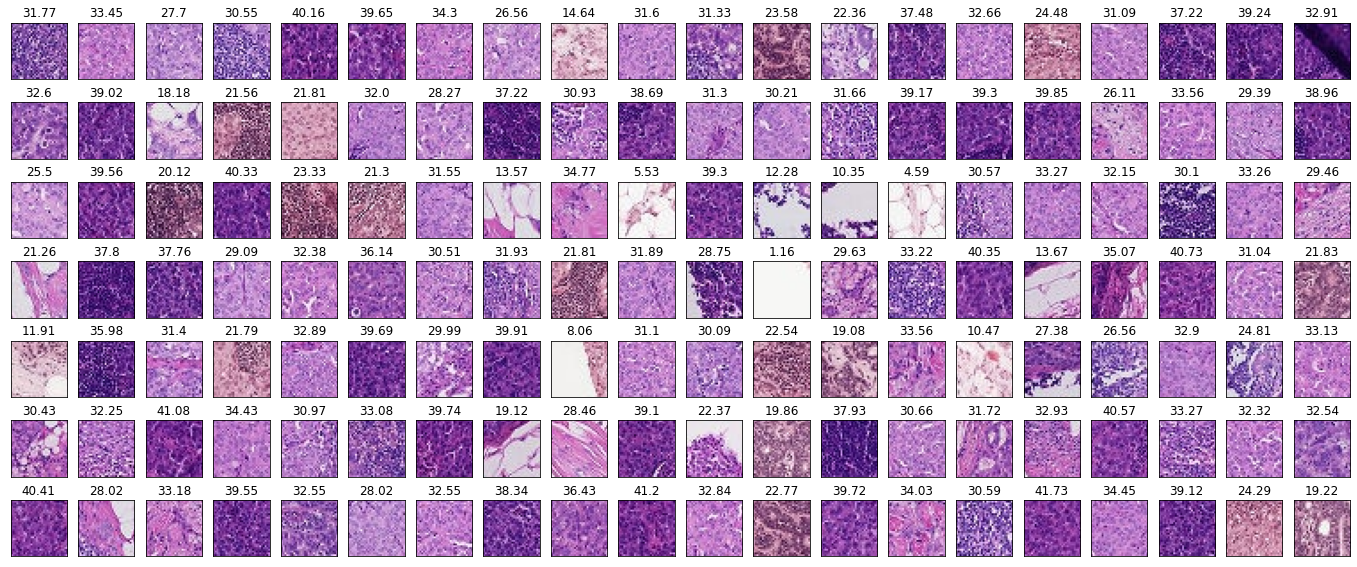

time: 5.96 s


In [0]:
# Check the patches with tumor to see if they contain cells
index_shuffle = np.arange(len(slide_patches_tumor))
np.random.shuffle(index_shuffle)
dim_axis = [20, 7]
fig = plt.figure(figsize=(24,10))
for i in range(dim_axis[1]):
    for j in range(dim_axis[0]):
        ax = fig.add_subplot(dim_axis[1], dim_axis[0], i*dim_axis[0]+j+1)
        plt.imshow(slide_patches_tumor[index_shuffle[i*dim_axis[0]+j]])
        im_gray = rgb2gray(slide_patches_tumor[index_shuffle[i*dim_axis[0]+j]])
        std_cross_channel = np.std(slide_patches_tumor[index_shuffle[i*dim_axis[0]+j]], axis=-1)
        # ax.set_title(str(round(np.mean(im_gray), 2)) + ", " + str(round(np.mean(std_cross_channel), 2)))
        ax.set_title(str(round(np.mean(std_cross_channel), 2)))
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)

#### Save the dataset to drive with pickle

In [0]:
variable_folder =  "/content/drive/My Drive/Dataset"
if os.path.isdir(variable_folder)==False:
    os.mkdir(variable_folder)

# Save the variables    
with open(os.path.join(variable_folder, "dataset_preprocessed.pkl"), 'wb') as f:
    pickle.dump([dataset_patches, dataset_label], f, protocol=-1)

time: 1.52 s


# Extract data for test (the last 2/21 slides)

### Get the path of original dataset from google drive folder (assumming data is stored in there)

In [0]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive/')

In [4]:
# Get the slides and masks path
import re

slides_dir = "/content/drive/My Drive/slides"
list_files = os.listdir(slides_dir)

def filter_path(file_path):
    if re.findall("[0-9].tif", file_path):
        # Slide
        return 1
    elif re.findall("_mask.tif", file_path):
        # Mask
        return 2
    else:
        return 0

name_slides = list(filter(lambda x: filter_path(x) == 1, list_files))
name_masks = list(filter(lambda x: filter_path(x) == 2, list_files))

# Make full path
path_slides = []
path_masks = []
for name_slide in name_slides[-2:]:
    # Skip slide 38, no mask file
    if name_slide == "tumor_038.tif":
        continue

    name_mask = name_slide[:-4] + "_mask.tif"
    path_slides.append(os.path.join(slides_dir, name_slide))
    path_masks.append(os.path.join(slides_dir, name_mask))
    assert name_slide == (name_mask[:-9] + ".tif")
    assert name_mask in name_masks

# Check the paths
for path_slide, path_mask in zip(path_slides, path_masks):
  print(path_slide, path_mask)

/content/drive/My Drive/slides/tumor_110.tif /content/drive/My Drive/slides/tumor_110_mask.tif
/content/drive/My Drive/slides/tumor_101.tif /content/drive/My Drive/slides/tumor_101_mask.tif
time: 24 ms


### Functions to read images and extract patches

In [5]:
# Read a region from the slide and return a numpy RBG array
from skimage.color import rgb2gray
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

# Make patches (Note that here we include all patches, even those without cells.
# This is important to check if our patch extraction works. 
# So this is recommended to use first to check. The downside is it takes a lot of RAM for high resolution)
def make_patch_set_include_all(slide_paths, mask_paths, patch_size=100, level=4):
    slide_patches = []
    tumor_indicator = []
    threshold_std = 5
    threshold_intensity = 0.2

    for slide_path, mask_path in zip(slide_paths, mask_paths):
        slide_whole = open_slide(slide_path)
        tumor_mask = open_slide(mask_path)
        n_step_width = tumor_mask.level_dimensions[level][0] // patch_size
        n_step_height = tumor_mask.level_dimensions[level][1] // patch_size
        downsample_factor = tumor_mask.level_downsamples[level]                 
        for step_width in range(n_step_width):
          for step_height in range(n_step_height):
              slide_window = [int(patch_size * step_width * downsample_factor), int(patch_size * step_height * downsample_factor)] 

              # Slide
              slide_patch = read_slide(slide_whole, 
                                    x=slide_window[0], 
                                    y=slide_window[1], 
                                    level=level, 
                                    width=patch_size, 
                                    height=patch_size)   
                        
              # Mask
              im_mask = read_slide(tumor_mask, 
                                    x=slide_window[0], 
                                    y=slide_window[1], 
                                    level=level, 
                                    width=patch_size, 
                                    height=patch_size) 
              
              # Save all patches
              slide_patches.append(slide_patch)  
              if np.sum(im_mask[:,:,0]) > 0:
                tumor_indicator.append(1)
              else:
                tumor_indicator.append(0)

    return slide_patches, tumor_indicator

time: 33.6 ms


### Extract the patches

In [0]:
# Extract the patches and labels
level = 3
patch_size = 32
slide_patches, tumor_indicator = make_patch_set_include_all(path_slides, path_masks, patch_size=patch_size, level=level)


time: 1min 3s


### Get the original slides and masks

In [0]:
# Load the whole slide
slides_original = []
masks_original = []
for path_slide, path_mask in zip(path_slides, path_masks):
    slide_whole = open_slide(path_slide)
    im_width =  slide_whole.level_dimensions[level][0]
    im_height =  slide_whole.level_dimensions[level][1]
    im_slide_whole = read_slide(slide_whole, 
                          x=0, 
                          y=0, 
                          level=level, 
                          width=im_width, 
                          height=im_height)   
    slides_original.append(im_slide_whole)
            
    # Load the whole mask
    tumor_mask = open_slide(path_mask)
    im_mask_whole = read_slide(tumor_mask, 
                          x=0, 
                          y=0, 
                          level=level, 
                          width=im_width, 
                          height=im_height)   
    masks_original.append(im_mask_whole)

time: 24.8 s


### Save the test dataset

In [0]:
# Save the variables    
variable_folder =  "/content/drive/My Drive/Dataset"
file_name = "dataset_test" + "_level" + str(level) + ".pkl"
if os.path.isdir(variable_folder)==False:
    os.mkdir(variable_folder)

with open(os.path.join(variable_folder, file_name), 'wb') as f:
    pickle.dump([slide_patches, tumor_indicator, slides_original, masks_original], f, protocol=-1)

time: 21.1 s
